### Script for identifying fronts in Bukovsky CONUS regions (1995–2017)
### in order to link to flood characteristics
### date created: 22 June 2021
### author: Erin Dougherty (doughert@ucar.edu)

In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from netCDF4 import Dataset, num2date
from datetime import datetime, date, timedelta
import glob
import xarray as xr
from dask.distributed import Client
#from wrf import getvar, ALL_TIMES

### import 850 hPa theta_e over the CONUS

In [2]:
import os.path

thetae_850 = []

for file in sorted(glob.glob(os.path.join('/glade/work/doughert/asp/flood_storm_types/era5_*/era5_thetae_*.nc'))):
    print(file)
    file_match = xr.open_dataset(file)
    file_match.close()
    thetae_850.append(file_match)

/glade/work/doughert/asp/flood_storm_types/era5_1995/era5_thetae_1995.nc
/glade/work/doughert/asp/flood_storm_types/era5_1996/era5_thetae_1996.nc
/glade/work/doughert/asp/flood_storm_types/era5_1997/era5_thetae_1997.nc
/glade/work/doughert/asp/flood_storm_types/era5_1998/era5_thetae_1998.nc
/glade/work/doughert/asp/flood_storm_types/era5_1999/era5_thetae_1999.nc
/glade/work/doughert/asp/flood_storm_types/era5_2000/era5_thetae_2000.nc
/glade/work/doughert/asp/flood_storm_types/era5_2001/era5_thetae_2001.nc
/glade/work/doughert/asp/flood_storm_types/era5_2002/era5_thetae_2002.nc
/glade/work/doughert/asp/flood_storm_types/era5_2003/era5_thetae_2003.nc
/glade/work/doughert/asp/flood_storm_types/era5_2004/era5_thetae_2004.nc
/glade/work/doughert/asp/flood_storm_types/era5_2005/era5_thetae_2005.nc
/glade/work/doughert/asp/flood_storm_types/era5_2006/era5_thetae_2006.nc
/glade/work/doughert/asp/flood_storm_types/era5_2007/era5_thetae_2007.nc
/glade/work/doughert/asp/flood_storm_types/era5_200

In [3]:
thetae_850_allyears = xr.merge(thetae_850)

### determine where front is if thetae gradient > 4 K/ 100 km (Sprenger et al. 2017)
#### or 1.24 K/31 km (ERA5 res)

In [5]:
%%time
import metpy.calc as mpcalc
from metpy.units import units

theta_e_grad = []
fronty = []
frontx = []

for i in range(len(thetae_850_allyears['thetae'])):
    #print(i)
    grad = mpcalc.gradient(thetae_850_allyears['thetae'][i], coordinates=(thetae_850_allyears.latitude, 
                                                                          thetae_850_allyears.longitude))

    # get gradient in x and y directions
    grady = np.abs(grad[0].magnitude)
    gradx = np.abs(grad[1].magnitude)
    
    # nan out values that aren't fronts 
    grady[grady<3.6]= np.nan
    gradx[gradx<3.6]= np.nan
    
    theta_e_grad.append(grad)
    fronty.append(grady)
    frontx.append(gradx)

CPU times: user 1min 19s, sys: 11.5 s, total: 1min 30s
Wall time: 1min 32s


In [6]:
print(len(fronty))
print(np.shape(fronty[0]))
print(np.shape(frontx[0]))

33604
(97, 241)
(97, 241)


### plot fronts

In [7]:
from cartopy.io import shapereader
import geopandas as gp
from geopandas import GeoDataFrame

us_st = gp.GeoDataFrame.from_file(
    "/glade/work/doughert/flooddata/cb_2013_us_state_5m_2/cb_2013_us_state_5m.shp")
us_st.head()
state = us_st['geometry'].values[0:56]

56


### import Bukovsky climate regions

In [8]:
from cartopy.io import shapereader
import geopandas as gp
from geopandas import GeoDataFrame

conus_reg = gp.GeoDataFrame.from_file( "/glade/work/doughert/asp/flood_storm_types/Bukovsky_conus_no_overlap/Bukovsky_conus_no_overlap.shp")
conus_reg.head()
print(len(conus_reg))

regions = conus_reg['geometry'].values

9


In [9]:
conus_reg['region_list'] = ['Pac_NW', 'Pac_SW', 'MountainW', 'Desert', 'GP', 'Praire', 'South', 'Lakes', 'East']

### turn front locations into xarrays

In [10]:
frontx_xr = xr.DataArray(data=frontx, dims=["time","latitude", "longitude", ], 
                         coords=dict(
                             time=thetae_850_allyears['time'].values, 
                             latitude=thetae_850_allyears['thetae'].latitude, 
                             longitude=thetae_850_allyears['thetae'].longitude), 
                        attrs=dict(
                        description='x-front')
                        )

### plot thetae gradient vs 850 thetae

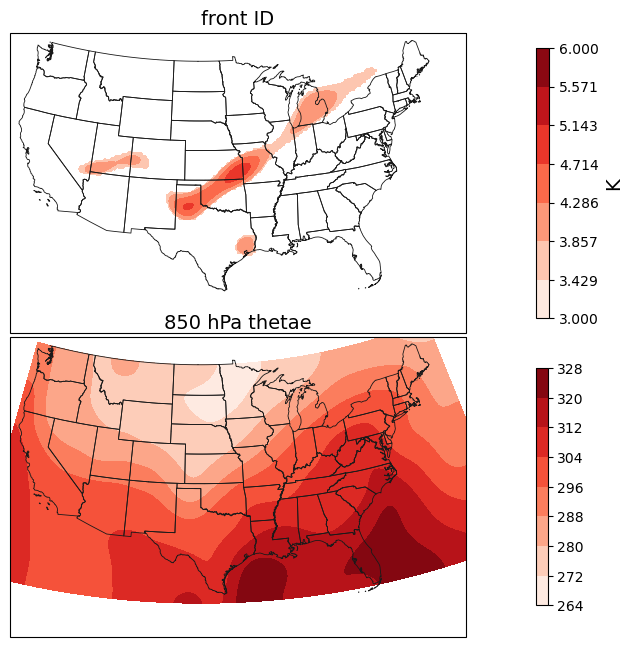

In [46]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as colors

fig = plt.figure(figsize = (18,8), dpi = 100)

## thetae y gradient
v = np.linspace(3, 6, 8,endpoint = True)
ax1 = plt.subplot(2, 1, 1,  projection=ccrs.LambertConformal(central_longitude=-100))
ax1.add_geometries(state, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.1', linewidth = 0.6)
ax1.set_extent([-120, -72, 21.5, 49], crs=ccrs.PlateCarree())
c1 = ax1.contourf(fronty_xr[0].longitude.values, fronty_xr[0].latitude.values, fronty_xr[0].values, v,
                    cmap='Reds', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(c1, orientation = 'vertical', ax=ax1, shrink=0.9)
ax1.set_title('front ID', fontsize=14)

## 850 thetae 
v = np.linspace(3, 6,4,endpoint = True)
ax2 = plt.subplot(2, 1, 2,  projection=ccrs.LambertConformal(central_longitude=-100))
ax2.add_geometries(state, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.1', linewidth = 0.6)
ax2.set_extent([-120, -72, 21.5, 49], crs=ccrs.PlateCarree())
c2 = ax2.contourf(fronty_xr[0].longitude.values, fronty_xr[0].latitude.values, thetae_850_allyears['thetae'][0].values, 
                    cmap='Reds', transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(c2, orientation = 'vertical', ax=ax2, shrink=0.79)
cbar1.set_label('K', fontsize=14)
ax2.set_title('850 hPa thetae', fontsize=14)

plt.subplots_adjust(wspace=None, hspace=0.01)
plt.savefig('CONUS_frontid_850thetae_00Z_01Jan_1995.png', bbox_inches='tight', dpi=250)
plt.show()


#### turn into 0s if nan and 1 if not nan (i.e., a front)

In [14]:
%%time
objectx_id_01s = [frontx_xr[i].notnull().astype(int) for i in range(len(frontx_xr))]

CPU times: user 27.9 s, sys: 3.58 s, total: 31.5 s
Wall time: 31.5 s


In [15]:
%%time
timesx = [objectx_id_01s[i].time.values for i in range(len(objectx_id_01s))]

CPU times: user 396 ms, sys: 1.19 ms, total: 397 ms
Wall time: 396 ms


### turn object array features into polygons

In [18]:
%%time
import rasterio.features

objectx_id_01s_int = [objectx_id_01s[i].values.astype(rasterio.int32) for i in range(len(objectx_id_01s))]

CPU times: user 1.34 s, sys: 864 ms, total: 2.21 s
Wall time: 2.21 s


In [ ]:
%%time
x_coordsy = []
y_coordsy = []
timesy_all = []

for i in range(0,33604):
    for p in range(len(polygons_y[i])):
        x,y = polygons_y[i][p].exterior.coords.xy
        x_coordsy.append(np.array(x).astype(int))
        y_coordsy.append(np.array(y).astype(int))
        timesy_all.append(timesy[i])                                                  

### x front polygons 

In [22]:
import rasterio
import shapely

shapes_x = [rasterio.features.shapes(objectx_id_01s_int[i]) for i in range(len(objectx_id_01s))]

In [23]:
polygons_x = []

for i in range(len(objectx_id_01s)):
    poly = [shapely.geometry.Polygon(shape[0]["coordinates"][0]) for shape in shapes_x[i] if shape[1] == 1]
    polygons_x.append(poly)


#### get polygon coordinates (x front)

In [24]:
%%time
x_coordsx = []
y_coordsx = []
timesx_all = []

for i in range(0,33604):
    for p in range(len(polygons_x[i])):
        x,y = polygons_x[i][p].exterior.coords.xy
        x_coordsx.append(np.array(x).astype(int))
        y_coordsx.append(np.array(y).astype(int))
        timesx_all.append(timesx[i])                                                  

CPU times: user 9.63 s, sys: 60.8 ms, total: 9.69 s
Wall time: 9.71 s


#### get lon, lat corresponding to polygon x coords

In [26]:
poly_lonx = []

for c in range(len(x_coordsx)):
    lon_idx = x_coordsx[c]
    lon_vals = objectx_id_01s[0].longitude.values[lon_idx]-360
    poly_lonx.append(lon_vals)

In [27]:
poly_latx = []

for c in range(len(y_coordsx)):
    lat_idx = y_coordsx[c]
    lat_idx[np.where(lat_idx==97)]=96
    #print(lat_idx)
    lat_vals = objectx_id_01s[0].latitude.values[lat_idx]
    poly_latx.append(lat_vals)

In [28]:
from shapely.geometry import Polygon
polygon_geomx = [Polygon(zip(poly_lonx[c], poly_latx[c])) for c in range(len(y_coordsx))]

### turn into new polygon with lat/lon coords

In [31]:
from geopandas import GeoSeries, GeoDataFrame
geox_idx = np.arange(0, len(timesx_all), 1)

crs = {'init': 'epsg:4326'}
frontx_polygon = gp.GeoDataFrame(index=geox_idx, crs=crs, geometry=GeoSeries(polygon_geomx))    
frontx_polygon['time'] = timesx_all

/glade/u/home/doughert/miniconda3/envs/pangeo3/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [39]:
frontx_polygon['geometry'] = frontx_polygon.buffer(0)

In [40]:
print(frontx_polygon.iloc[0:5])

                                            geometry                time
0  POLYGON ((-122.50000 45.50000, -121.75000 45.5... 1995-01-01 00:00:00
1  POLYGON ((-96.25000 30.00000, -95.75000 30.000... 1995-01-01 00:00:00
2  POLYGON ((-122.50000 46.00000, -121.50000 46.0... 1995-01-01 06:00:00
3  POLYGON ((-96.25000 29.25000, -95.00000 29.250... 1995-01-01 06:00:00
4  POLYGON ((-122.25000 47.00000, -121.75000 47.0... 1995-01-01 12:00:00


#### test polygon

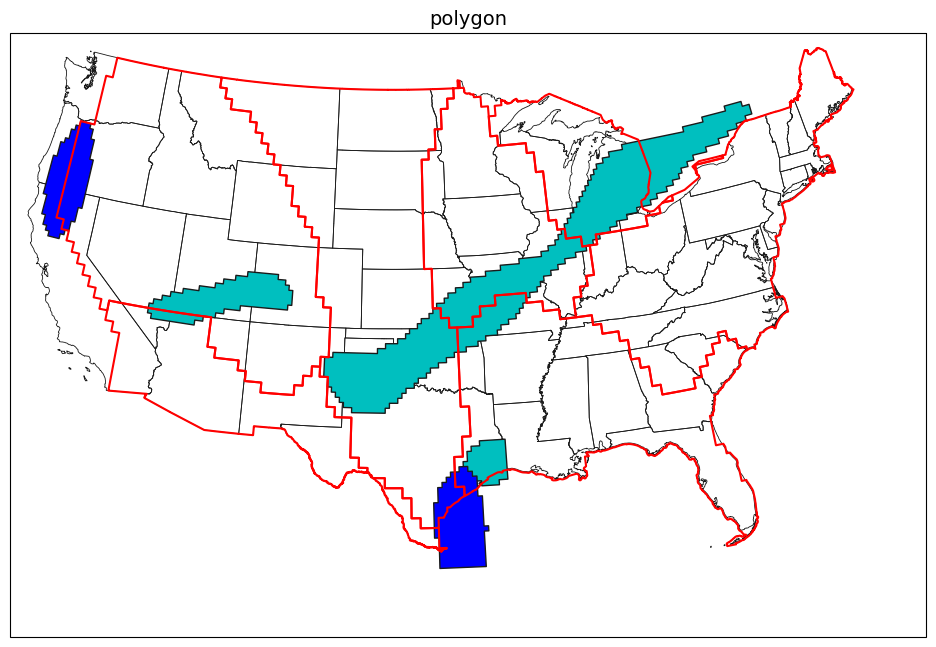

In [74]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as colors

fig = plt.figure(figsize = (18,8), dpi = 100)

## original polygons
ax2 = plt.subplot(1, 1, 1,  projection=ccrs.LambertConformal(central_longitude=-100))
ax2.add_geometries(state, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.1', linewidth = 0.6)
ax2.add_geometries(fronty_polygon['geometry'], crs=ccrs.PlateCarree(), facecolor='c', edgecolor='0.1', zorder=1)
ax2.add_geometries(frontx_polygon['geometry'], crs=ccrs.PlateCarree(), facecolor='b', edgecolor='0.1', zorder=1)
ax2.add_geometries(regions[2:3], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax2.add_geometries(regions[3:4], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax2.add_geometries(regions[4:5], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax2.add_geometries(regions[5:6], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax2.add_geometries(regions[6:7], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax2.add_geometries(regions[7:8], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax2.add_geometries(regions[8:9], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax2.set_extent([-120, -72, 21.5, 49], crs=ccrs.PlateCarree())
ax2.set_title('polygon', fontsize=14)


#plt.savefig('CONUS_frontid_850thetae_00Z_01Jan_1995.png', bbox_inches='tight', dpi=250)
plt.show()


### designate region as having frontal influence if frontal object intersects region

In [41]:
%%time
frontx_region = []
frontx_date = []
front_count = []

for f in range(len(conus_reg)):
    for t in range(len(frontx_polygon)):
        if (conus_reg['geometry'].iloc[f].intersects(frontx_polygon['geometry'].iloc[t])):
            frontx_region.append(conus_reg['region_list'].iloc[f])
            frontx_date.append(frontx_polygon['time'].iloc[t])
            front_count.append(1)
            

CPU times: user 4min 21s, sys: 1.97 s, total: 4min 23s
Wall time: 4min 23s


In [42]:
print(len(frontx_region))

149197


### make a df of fronts

In [43]:
frontx_df = pd.DataFrame({'region':frontx_region, 'date':frontx_date, 'occurrence':front_count})

In [44]:
print(len(frontx_df))
print(frontx_df[0:5])

149197
   region                date  occurrence
0  Pac_NW 1995-01-01 00:00:00           1
1  Pac_NW 1995-01-01 06:00:00           1
2  Pac_NW 1995-01-01 12:00:00           1
3  Pac_NW 1995-01-01 18:00:00           1
4  Pac_NW 1995-01-02 00:00:00           1


### resample to daily resolution

In [45]:
%%time
frontx_daily = frontx_df.groupby('region').resample('D', on='date').mean().reset_index()

CPU times: user 61 ms, sys: 1.95 ms, total: 62.9 ms
Wall time: 498 ms


In [46]:
print(frontx_daily[0:5])

   region       date  occurrence
0  Desert 1995-01-01         1.0
1  Desert 1995-01-02         NaN
2  Desert 1995-01-03         1.0
3  Desert 1995-01-04         1.0
4  Desert 1995-01-05         1.0


In [47]:
print(len(frontx_daily))

75534


In [48]:
frontx_daily.to_csv('x_fronts_daily_bukovsky_regions.csv')